# CSCI6908: Assignment 3 - Neural Machine Translation.

**<span style="color:red">Deadline: Monday, March 3rd, 2025</span>**

# Part 0: Introduction

In this assignment, you will build, train, and evaluate a neural machine translation system. The system will be in the form of a seq2seq neural network, that takes as input a French sequence and translates it to English. Unlike the previous assignment where the whole system was built from scratch, you will now use `pytorch`, a Python framework for building deep learning models.  

This assignment assumes some familiarity with the framework. You can consult `pytorch`'s [documentation](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) to brush up on your knowledge.


The main goals of this assignment are:  
  - Train a BPE-based tokenizer to transform input from raw textual representation in an adequate one that can serve as input for the neural model.
  - Use Gated Recurrent Units (GRU) as building blocks to create a seq2seq model for neural machine translation.
  - Build different variations of seq2seq models for French-to-English translation.
  - Evaluate said models using machine-translation metrics such as BLEU.

## Requirements
Before you can start, make sure you install the dependencies list in the `requirements.txt` file. It is advised that you use a Python virtual enviornment. You can consult how you can a add virtual enviornment to Jupyter's kernal through this [guide](https://janakiev.com/blog/jupyter-virtual-envs/).  
In this assignment you will train two seq2seq models for a duration $25K$ steps (not epochs). On a Mabook Pro with an M2 chip, the training time took $\sim 50$ minutes and $90$ minutes respectively. If you do not have access to enough computational resources here are your options:
- Use [Google Colab](https://colab.research.google.com/).
- Use Dal's Brookside and Calvert [servers](https://www.dal.ca/faculty/computerscience/for-faculty-staff/technical-services.html). Check under _Academic compute enviornment_ > _GPU Processing_. There you will find links that redirect you to the Jupyter lab interface hosted on these servers.
- Reduce the number of training step.

**Please note that your grade will depend on the implementation and not on the running results. Hence, if you cannot train these models fully, you can still get the full grade if your implementation is correct.**

## Submission Guidelines
Add the TA as _Maintainer_ to your fork and submit your fork's URL on Brightspace. Push the modifications you have made on this notebook to your fork.  
**Do NOT alter any of the functions/classes in the Python files of this repository. You are however free to add functions if you need to. If you do, make sure to push the relevant changes**.

## Submission of SDAs
For this assignment, SDAs should be submitted through Brightspace. You will find the submission box under _Assignments_ > _SDA_. **<span style="color:red">Please note that you are only allowed to submit 2 SDAs for this course. Hence, if you already reached that limit, you can no longer submit one. In addition, no SDA will be considered if sent by email. All SDAs should be submitted through Brightspace prior to the deadline.</span>**  

If you have any questions, please do not hesitate to post them on the course’s Teams channel. If you have not joined already, you can do so by using this code: `ot45hmp`.

Good luck!


In [1]:
import os
data_path = os.path.join(".", "data")
bpe_files = os.path.join('.', "bpe_files")

## Part 1: Background and Data Preparation

The dataset contains $\sim 259K$ pairs of French and English sequences. It is taken from the work of [(Tiedemann, 2012)](https://aclanthology.org/L12-1246/). The dataset is stored in `data/data.txt`. Each line follows this form: `<ENGLISH-SENTENCE> \t <FRENCH-SENTENCE>`.  
First, we need to create a vocabulary using Byte Pair Encoding.  

Byte Pair Encoding (BPE) is a data compression technique adapted for use in neural machine translation to handle the vocabulary of words in a text corpus. In NMT, we use BPE to segment words into subword units (_i.e._, tokens), which helps in managing rare and out-of-vocabulary words by breaking them down into smaller, more frequent components. For instance, instead of treating the word `eating` as a part of the vocabulary, we subdivide into `eat` and `ing` and treat these tokens as part of the vocab.

Here is how BPE works:

1. **Initialization**: Start with a vocabulary of individual characters.
2. **Frequency Counting**: Count the frequency of each pair of adjacent symbols (initially characters) in the text.
3. **Merging**: Replace the most frequent pair with a new symbol and add it to the vocabulary.
4. **Iteration**: Repeat the counting and merging steps until a predefined vocabulary size is reached or no more pairs can be merged.

Iteratively, BPE creates a set of subword units that can represent any word in the text, even if it was not seen during training. This approach helps in reducing the vocabulary size while maintaining the ability to generate and understand rare or complex words, improving the efficiency and performance of neural machine translation models.  

During the lecture you will get into more details how BPE works. For now, all you need to know is BPE is a way to construct a vocabulary given a corpus.

In [2]:
# IMPORTS
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Tasks:

Your first task is to read the `data/data.txt` file and create two files: `data/train.en`, `data/train.fr`. In the `train.en` file each line should represent the English sentence extracted from the pairs stored in `data/data.txt` after applying the following operations: 
1. Convert the string into lowercase.
2. Tokenize the string using the `WordPunctTokenizer` class into a list of tokens.
3. Convert the list of tokens back into one string using whitespace as a delimiter.

Same logic applies for `train.fr`, but for French sentences.

In [3]:
# Your code goes here
with open(os.path.join(data_path, 'data.txt'), 'r') as file:
    lines = file.readlines()

tokenizer = WordPunctTokenizer()

english_sentences = []
french_sentences = []

for line in lines:
    english, french = line.strip().split('\t')
    
    lowercase_english = english.lower()
    english_tokens = tokenizer.tokenize(lowercase_english)
    english_sentences.append(' '.join(english_tokens))
    
    lowercase_french = french.lower()
    french_tokens = tokenizer.tokenize(lowercase_french)
    french_sentences.append(' '.join(french_tokens))

with open(os.path.join(data_path, 'train.en'), 'w') as file:
    for sentence in english_sentences:
        file.write(sentence + '\n')

with open(os.path.join(data_path, 'train.fr'), 'w') as file:
    for sentence in french_sentences:
        file.write(sentence + '\n')

Once you perform the instructions mentioned above, execute the following cell which is responsible of:
1. Learning a set of merges using BPE.
2. Creating a vocabulary of size $8000$.
3. Converting the `train.en` and `train.fr` files into tokenized samples using BPE and the learned merges and storing the results into `train.bpe.en` and `train.bpe.fr`.

In [4]:
# build and apply bpe vocs
bpe = {}
for lang in ['en', 'fr']:
    learn_bpe(open(os.path.join(data_path, f'train.{lang}')), open(os.path.join(bpe_files, f'bpe_rules.{lang}'), 'w'), num_symbols=8000)
    bpe[lang] = BPE(open(os.path.join(bpe_files, f'bpe_rules.{lang}')))

    with open(os.path.join(data_path, f'train.bpe.{lang}'), 'w') as f_out:
        for line in open(os.path.join(data_path, f'train.{lang}')):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:04<00:00, 1745.58it/s]


If everything goes well, you should find the two files `train.bpe.en` and `train.bpe.fr` created in the `data` folder.  

Now, we will convert the raw tokens into numerical format and create training and testing sets. This will be achieved through `numpy` and the `Vocab` class located in the `vocab.py` file.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
data_inp = np.array(open(os.path.join(data_path, 'train.bpe.fr')).read().split('\n'))
data_out = np.array(open(os.path.join(data_path, 'train.bpe.en')).read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: la majorité de bactéries sont capables de passer à un état en l dépour@@ vu de paroi cellulaire .
out: most bacteria are capable of changing into a cell wall - defici@@ ent ( c@@ w@@ d ) l - form state .

inp: les résultats ont montré que l ' expression de la ch@@ d@@ 1 pourrait être liée à la progression du cancer de la prostate .
out: results also showed that ch@@ d@@ 1 expression might be relevant for prostate cancer progression .

inp: les noyaux des eu@@ caryo@@ tes supérieurs ( organismes dont les noyaux sont ent@@ ou@@ rés de membranes ) contiennent de multiples corps su@@ b - nucléaires qui inter@@ viennent dans des processus moléculaires distinc@@ ts , allant de la réplication de l ’ adn à la transcription et au traitement de l ’ arn .
out: the nucle@@ i of higher eu@@ karyo@@ te ( organisms whose nucle@@ i are enc@@ lo@@ sed by membranes ), contain multiple sub - nuclear bodies that mediate distinct molecular processes , ranging from dna replication to rna transcription 

In [7]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [8]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
[np.str_('en pratique'), np.str_('impact futur'), np.str_('plani@@ fier'), np.str_('lien utile :'), np.str_('2015 et après')]

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2575, 5590,    1,    1],
        [   0, 3581, 3211,    1,    1],
        [   0, 5423, 3022,    1,    1],
        [   0, 4106, 7486,  107,    1],
        [   0,   67, 2784,  634,    1]])

back to words
['en pratique', 'impact futur', 'plani@@ fier', 'lien utile :', '2015 et après']


You can see from above that input batch (the variable `batch_ids`) is of dimension $(B\times seq\_len)$, where $B$ is the number of samples and $seq\_len$ is the length of each sample. In addition, you can notice how each sample starts with `[BOS]` token and ends with an `[EOS]` token. Some samples are padded to have a length of $seq\_len$ by adding multiple `[EOS]` tokens on the right.

Using the code below, will plot the distribution of sequence lengths of the source and target samples. We do this to get an idea regarding the training and inference times.

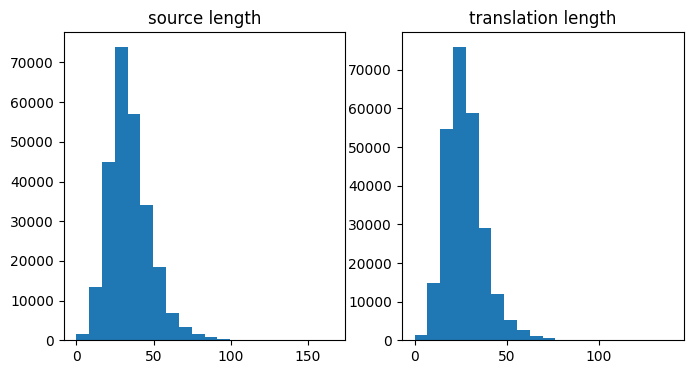

In [9]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

## Part 2: Bulding the seq2seq Model

During the lecture, you have encountered a variant of RNNs called Long Short-Term Memory (LSTM) that addresses some of the limitations that are present in vanilla RNNs.  
In this assignment, you will use another type of RNNs: Gated Recurrent Units or GRUs. The GRU bears a similarity with LSTM, in the sense that it also implements a gating mechanism. However, it does not contain a context vector or an output gate, making it smaller, in terms of parameter count, compared to the LSTM. If you are interested in the interals of such layer, you can refer to the following [resource](https://d2l.ai/chapter_recurrent-modern/gru.html).

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### GRU-based seq2seq Model

As we have mentioned earlier, you will develop GRU-based seq2seq model that translates French sequences to English. Concretely, the model is composed of two components: an encoder and a decoder. This model translates sequences (e.g., sentences) from an input language to an output language. Here’s the high-level workflow:  

1. Input Processing (Encoder): 
   - Input tokens are converted into dense vector representations or embeddings using an embedding layer.  
   - Then, a **GRU-based encoder** processes the entire input sequence into a _context vector_ (final hidden state).  

2. Decoding Initialization: 
   - The encoder’s final hidden state is transformed into an initial state for the decoder.  

3. Output Generation (Decoder):  
   - The decoder uses a **GRUCell** to generate output tokens **step-by-step**:  
     - At each step, it embeds the previous output token (or the start token initially).  
     - The GRU cell updates its hidden state using this embedding and the previous state.  
     - A linear layer maps the updated state to *logits* (scores) over the output vocabulary.  
   - During **training**, the decoder uses reference output tokens.  
   - During **inference**, it greedily selects the highest-scoring token at each step.  

---

## Tasks 
1. Complete the `__init__` method of a simple encoder-decoder sequence-to-sequence model in PyTorch:  
    1. Use embedding layers for both input and output vocabularies.  
    2. Include a **single-layer GRU encoder**.  
    3. Initialize a decoder that:  
       - Starts with a hidden state derived from the encoder’s final state via a linear layer.  
       - Uses a **GRUCell** for step-wise token generation.  
       - Maps decoder hidden states to scores over the output vocabulary _i.e._ logits.

**N.B:** Make sure that you do NOT change the name of the variable in the `__init__` function. If you do so, the code would break.

2. Complete the implementation of `decode_step` function that generates the next deoder states. This function will be used by `decode` method to generate output tokens during training. Similarly, it will be used by the `decode_inference` method during inference.

You can consult the documentation of the following layers:
- [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html).
- [`nn.GRU`](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html). Note that you need to set `batch_first=True` so that this layer process batches.
- [`nn.GRUCell`](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html).
- [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html).


In [14]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super(BasicModel, self).__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]

        ## Your code goes gere ##
        # Embed the previous tokens
        prev_emb = self.emb_out(prev_tokens)

        # Update the GRU state
        new_gru0_state = self.dec0(prev_emb, prev_gru0_state)

        # Compute output logits
        logits = self.logits(new_gru0_state)

        # Prepare the new state (which is a list containing only the new GRU state)
        new_state = [new_gru0_state]
           
        return new_state, logits
       
    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

The following cell is for sanity check. If all assertions pass, then most likely your implementation is correct. If not, go back and see if you have missed something.

In [15]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [16]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
generator astic ogenic tility photonics removing pha mediated aling roll@@ fal@@ inhe@@ nov@@ validating bal@@ created whole substrates special â@@ competitive band optimal jet tenance
generator astic ogenic tility photonics removing pha mediated aling roll@@ fal@@ inhe@@ nov@@ validating bal@@ created whole substrates special â@@ competitive band optimal jet tenance
generator astic ogenic tility photonics removing pha mediated aling roll@@ fal@@ inhe@@ nov@@ validating bal@@ created whole substrates special â@@ competitive band optimal jet tenance


### Training loss

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but **excluding** PAD, and $\theta$ represents the model's weights.

For each target sequence $(Y = [\text{BOS}, y_1, y_2, ..., \text{EOS}])$, the model predicts the probability $p(y_t \mid y_1, \dots, y_{t-1}, X)$ for every token $y_t$ in $Y$, starting from $\text{BOS}$.  

Through the minimization of this loss, the model learns to assign high probabilities to the correct tokens in the target sequence, conditioned on both the input $X$ and the autoregressive history $(y_1, \dots, y_{t-1})$. This aligns with the goal of accurate, end-to-end sequence generation.

## Tasks:
- Complete the implementation of the `compute_loss` function following the formula above.

In [17]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param model: the seq2seq model
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """

    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model.decode(model.encode(inp), out, **flags)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = F.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = torch.sum(logprobs_seq * targets_1hot, dim=-1)
    # ^-- this will select the probability of the actual next token.

    # Compute the loss only where mask is True
    masked_loss = -logp_out * mask

    # Sum the losses
    total_loss = masked_loss.sum()

    # Compute the total number of tokens (sum of sequence lengths)
    total_tokens = mask.sum()

    # Average cross-entropy over tokens where mask == True
    average_loss = total_loss / total_tokens

    return average_loss  # average loss, scalar

Execute the cell below to perform a sanity check of your implementation.

In [18]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(6.8904, grad_fn=<DivBackward0>)


### Evaluation using BLEU

BLEU (Bilingual Evaluation Understudy) measures how well a machine-generated translation matches one or more human reference translations. It computes a score between 0 (no overlap) and 100 (perfect match) by:  

- N-gram Precision: Checking how many word/phrase fragments (n-grams) in the candidate translation appear in the references.  

- Brevity Penalty: Penalizing overly short translations to avoid inflated scores from trivial matches.

The code below computes BLEU at the corpus level (across all sentences), with smoothing to handle edge cases (e.g., missing n-grams). The higher BLEU score is the better translation quality.

In [19]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

Execute below to get the BLEU score of the current untrained model on the evaluation set.

In [20]:
compute_bleu(model, dev_inp, dev_out)

0.0020470400307099883

## Training the seq2seq Model

Now, we have everything ready to train the NMT model. The training loop will render the training loss and BLEU score values on the evaluation set every $100$ steps. If your implementation is correct, you should see a decreasing training loss curve and increasing BLEU score curve. Execute the two cells below to start the model training.

In [21]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

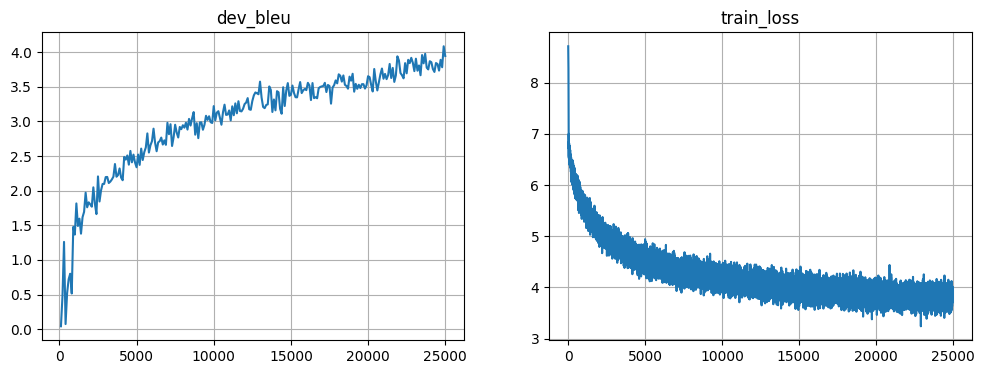

Mean loss=3.811


100%|██████████| 25000/25000 [1:31:07<00:00,  4.57it/s]


In [22]:
pbar = tqdm(range(25000))
for _ in pbar:
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    # Training step
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

## Part 3: Adding Attention

Now that you have built a functional vanilla seq2seq model, such model has some limitations—particularly in handling long sequences or retaining fine-grained input context. To address this, you will enhance the decoder by integrating an attention mechanism. Unlike the vanilla model, which relies solely on a fixed context vector from the encoder, attention allows the decoder to dynamically "focus" on relevant parts of the input sequence at each decoding step. This step equips the model with the ability to better align input and output sequences, improving translation quality and robustness. Your task is to implement the attention layer and integrate it into the existing architecture.

### Creating an Attention Layer

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$, input mask and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Apply input mask to the logits so that their probabilities is set to 0 later
$$a_t = -\inf \text{for masked/padded encoder positions}$$
* Get probabilities from logits,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

### Tasks
Your task is to complete the implementation of the `__init__` and `forward` methods of the `AttentionLayer` class.

In [ ]:
class AttentionLayer(nn.Module):
    def __init__(self, layer_name: str, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = layer_name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        # create trainable parameters
        ## Your code goes here
        self.linear_e = nn.Linear(enc_size, hid_size)
        self.linear_d = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1, bias=False)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        enc_proj = self.linear_e(enc)  # [batch_size, ninp, hid_size]
        dec_proj = self.linear_d(dec).unsqueeze(1)  # [batch_size, 1, hid_size]

        # Apply activation function
        hidden = self.activ(enc_proj + dec_proj)  # [batch_size, ninp, hid_size]

        logits = self.linear_out(hidden).squeeze(-1)  # [batch_size, ninp]

        # Apply mask. Hint check torch.where
        masked_logits = torch.where(inp_mask == 0, logits, torch.tensor(float('-inf')).to(logits.device))

        # Compute attention probabilities
        probs = F.softmax(masked_logits, dim=-1)  # [batch_size, ninp]

        # Compute attention response using enc and probs
        attn = torch.sum(probs.unsqueeze(-1) * enc, dim=1)  # [batch_size, enc_size]

        return attn, probs

### Integrating the Attention Layer in the seq2eq Model

The attention layer will be used in the decoder part. On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

### Tasks
1. Complete the `__init__` method of the attention-based encoder-decoder sequence-to-sequence model in PyTorch:  
    1. The structure is the same as the `BasicModel` class, but adds an `AttentionLayer` as an extra component. 
         
2. Complete the implementation of the `encode` and `decode_step` functions so that the attention mechanism is considered.

In [24]:
class AttentiveModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc = nn.GRU(emb_size, hid_size, batch_first=True)
        
        self.dec = nn.GRUCell(emb_size + attn_size, hid_size)
        self.attn = AttentionLayer("attention", hid_size, hid_size, attn_size)
        self.out = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_emb = self.emb_inp(inp)
        enc_seq, _ = self.enc(inp_emb)

        # Create encoder mask
        inp_mask = (inp != self.inp_voc.eos_ix).float()

        # Initial decoder hidden state (last encoder state)
        dec_hidden = enc_seq[:, -1]

        # Apply attention layer from initial decoder hidden state
        first_attn, first_attn_probas = self.attn(enc_seq, dec_hidden, inp_mask)

        # Build first state
        first_state = [dec_hidden, enc_seq, inp_mask, first_attn, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        prev_hidden, enc_seq, inp_mask, prev_attn, prev_attn_probas = prev_state
        
        # Embed previous tokens
        prev_emb = self.emb_out(prev_tokens)

        # Concatenate previous embedding and attention response
        dec_input = torch.cat([prev_emb, prev_attn], dim=-1)

        # Run decoder GRU
        new_hidden = self.dec(dec_input, prev_hidden)

        # Apply attention
        attn, attn_probas = self.attn(enc_seq, new_hidden, inp_mask)

        # Compute output logits
        output_logits = self.out(new_hidden)

        new_state = [new_hidden, enc_seq, inp_mask, attn, attn_probas]
        return new_state, output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

### Training the new seq2seq model

In [25]:
from IPython.display import clear_output
from tqdm import tqdm, trange
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

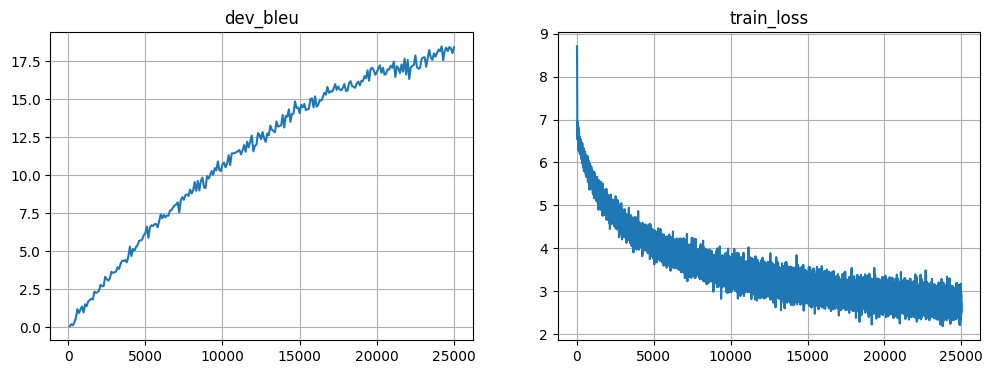

Mean loss=2.724


100%|██████████| 25000/25000 [3:52:19<00:00,  1.79it/s]


In [26]:
pbar = tqdm(range(25000))
for _ in pbar:
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    # Training step
    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

If the implementation is correct, the training behaviour of `AttentiveModel` should be similar to that of the `BasicModel`. The difference is that the `AttentiveModel` model would have a faster convergence, _i.e._, the training loss decreases faster, and the BLEU score would be higher.

## Part 4: Rubric

Please note that partial grading will be handled on a case by case manner.

## Part 1 (/0.5):
- Preprocessing `train.en`: /0.25 pt
- Preprocessing `train.fr`: /0.25 pt

## Part 2 (/6):
### Basic seq2seq:
- Implementation of the `__init__` function: /2
- Implementation of the `decode_inference` function: /2
- Implementation of the loss function: /2

## Part 3 (/7.5):

### Attention layer:
- Implementation of the `__init__` function: /1
- Implementation of the `forward` function: /2

### Attention-based seq2seq:
- Completion of `__init__` function: /0.5
- Completion of `encode function`: /2
- Completion of `decode_step` function: /2


### Total: /14